## Kuramoto-Sivashinsky Equation Solvers
We include several solvers for the KS equation initial value problem with periodic boundary conditions $u(x,0) = u_0(x), u(0,t) = u(L,t)$. Each work by operator splitting, using a Crank-Nicholson scheme which is diagonal in Fourier space combined with a 2-step Adams-Bashforth method for estimating the action of the nonlinear operator. The KS equation reads:
$$ \partial_t u + \partial_x^2 u + \nu \partial_x^4 u + u \partial_x u = 0 $$
$$ \partial_t u = \mathcal{L} u + \mathcal{N} u$$
Where $\nu$ is viscosity. The nonlinear part can also be expressed as $\frac{1}{2}\partial_x (u^2)$, which is the form we shall be using in code. Using $\hat{u} = \mathcal{F} \{ u \}$ to refer to the Fourier transform of the spatial discretization of $u(t)$, and $k$ to refer to the spatial frequency, we observe that $u(x) = \hat{u}(k) e^{ikx}$, and thus $\partial_x \hat{u} = ik \hat{u}$ (for each k in the discretization of course). Using $u^+$ to denote the state one timestep into the future, and $u^-$ to denote the timestep before the present one, our equation becomes discretized in the CN + AB scheme as:
$$ \frac{\hat{u}^+ - \hat{u}}{\Delta t} = -\left[ (ik)^2 + \nu (ik)^4 \right] \frac{\hat{u}^+ + \hat{u}}{2} - (ik) \mathcal{F} \left\{ \frac{3}{2} u^2 - \frac{1}{2} (u^-)^2 \right\}$$
Solving for $\hat{u}^+$:
$$ \left(1 + \frac{\Delta t}{2} \mathcal{F}[\mathcal{L}] \right) \hat{u}^+ = \left(1 - \frac{\Delta t}{2} \mathcal{F}[\mathcal{L}] \right) \hat{u} - (ik) \mathcal{F} \left\{ \frac{3}{2} u^2 - \frac{1}{2} (u^-)^2 \right\} \Delta t $$
If we precompute $\mathcal{F}(u^2)$ and $\mathcal{F}((u^-)^2)$, this becomes a simple algebraic relation for each $k$, as we see in the codes below.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax.numpy.fft import fft, ifft, fftfreq
from jax import jit

from jax.config import config
config.update("jax_enable_x64", True)

# simulation grid
nu = 1
L = 100 
nx = 1024
nt = 4000

simulation_params = {'nu': nu, 'L': L, 'nx': nx, 'nt': nt}

# plot the result
def plot_KS(u,T,nx=nx,nt=nt):
    x = np.linspace( 0, L, nx)
    t = np.linspace( 0, T, nt)
    fig, ax = plt.subplots(figsize=(10,8))

    xx, tt = np.meshgrid(x, t)
    levels = np.linspace(-3.5, 3.5, 300)
    cs = ax.contourf(xx, tt, u, levels)
    fig.colorbar(cs)

    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(f"Kuramoto-Sivashinsky: L = {L}, nu = {nu}")

# initial conditions used for demo
T  = 200
x = np.linspace( 0, L,  nx)
u0 = np.cos((2 * np.pi * x) / L) + 0.1 * np.cos((4 * np.pi * x) / L)

In [12]:
"""NUMPY VERSION OF KS INTEGRATOR"""

def Numpy_Integrator(nu, L, nx, nt):
  def propagator(u0, T):
    dt = T/nt
    # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
    k = (2 * np.pi / L) * np.fft.fftfreq(nx) * nx

    # solution mesh in real and Fourier space
    u      = np.empty((nt, nx))
    u_hat  = np.empty((nt, nx), dtype=np.complex64)
    u_hat2 = np.empty((nt, nx), dtype=np.complex64)

    # set initial condition in real and Fourier space
    u[0]      = u0
    u_hat[0]  = (1 / nx) * np.fft.fft(u0)
    u_hat2[0] = (1 / nx) * np.fft.fft(u0**2)

    # Fourier Transform of the linear and nonlinear operators
    FL = (k ** 2) - nu * (k ** 4)
    FN = - (1 / 2) * (1j) * k

    # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
    CN1 = (1 + (dt / 2) * FL)
    CN2 = 1 / (1 - (dt / 2) * FL)

    # first timestep (no advanced restarting, just Euler)
    u_hat[1]  = CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt)

    # auxiliaries of first timestep
    u[1]      = nx * np.real(np.fft.ifft(u_hat[1]))
    u_hat2[1] = (1 / nx) * np.fft.fft(u[1]**2)

    # compute solution through time via finite difference method in Fourier space
    for j in range(1,nt-1): 
      # Cranck-Nicholson + Adams-Bashforth
      u_hat[j+1]  = CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt)
      #u_hat[j+1, abs(k) > nx/3] = 0
      
      # go back to real space
      u[j+1]      = nx * np.real(np.fft.ifft(u_hat[j+1]))
      u_hat2[j+1] = (1 / nx) * np.fft.fft(u[j+1]**2)
    
    return u
  
  return propagator
  
np_propagator = Numpy_Integrator(**simulation_params)
u_np = np_propagator(u0, T)

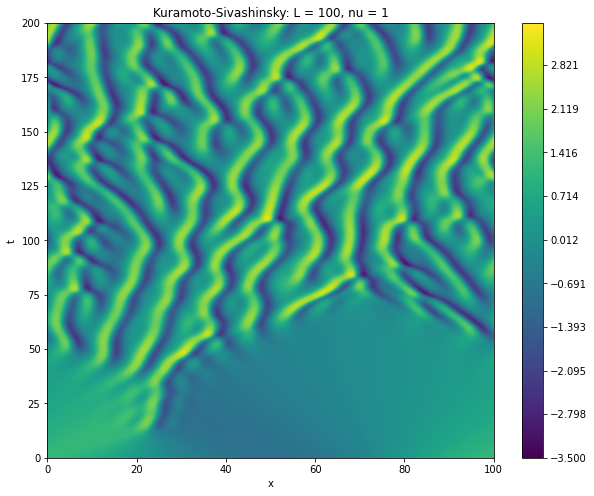

In [13]:
plot_KS(u_np, T)

TypeError: Shapes of x (4000, 4000) and z (4000, 1024) do not match

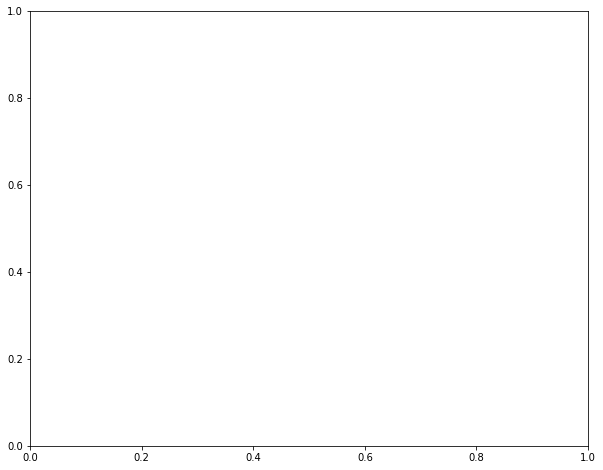

In [14]:
# comparison between 8000, 4000, 2000, and 1000 steps:
u_4 = u_np

prop8 = Numpy_Integrator(nu, L, nx, 8000)
u_8 = prop8(u0,T)
prop2 = Numpy_Integrator(nu, L, nx, 2000)
u_2 = prop2(u0,T)
prop1 = Numpy_Integrator(nu, L, nx, 1000)
u_1 = prop1(u0,T)

plot_KS(u_8[::2]-u_4, T, nt)
plot_KS(u_4[::2]-u_2, T, nt//2)
plot_KS(u_4[::4]-u_1, T, nt//4)

In [ ]:
"""UNCOMPILED JAX IMPLEMENTATION OF KS INTEGRATOR"""

Run_Uncompiled = False

def JAX_uncomplied():
  nu = 1
  L = 100 
  nx = 1024

  t0 = 0 
  tN = 200
  dt = 0.05
  nt = int((tN - t0) / dt)

  # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
  k = (2 * jnp.pi / L) * fftfreq(nx) * nx

  t = jnp.linspace(t0, tN, nt)
  x = jnp.linspace( 0, L,  nx)

  # solution mesh in real and Fourier space
  u      = jnp.empty((nt, nx), dtype=jnp.float64)
  u_hat  = jnp.empty((nt, nx), dtype=jnp.complex128)
  u_hat2 = jnp.empty((nt, nx), dtype=jnp.complex128)

  # set initial condition in real and Fourier space
  u      = u     .at[0].set( jnp.cos((2 * jnp.pi * x) / L) + 0.1 * jnp.cos((4 * jnp.pi * x) / L) )
  u_hat  = u_hat .at[0].set( (1 / nx) * fft(u[0])    )
  u_hat2 = u_hat2.at[0].set( (1 / nx) * fft(u[0]**2) )

  # Fourier Transform of the linear and nonlinear operators
  FL = (k ** 2) - nu * (k ** 4)
  FN = - (1 / 2) * (1j) * k

  # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
  CN1 = (1 + (dt / 2) * FL)
  CN2 = 1 / (1 - (dt / 2) * FL)

  # first timestep (no advanced restarting, just Euler)
  u_hat  = u_hat .at[1].set( CN2 * ( CN1 * u_hat[0] + FN * u_hat2[0] * dt) )

  # auxiliaries of first timestep
  u      = u     .at[1].set( nx * jnp.real(ifft(u_hat[1])) )
  u_hat2 = u_hat2.at[1].set( (1 / nx) * fft(u[1]**2)       )

  # compute solution through time via finite difference method in Fourier space
  for j in range(1,nt-1): 
    # Cranck-Nicholson + Adams-Bashforth
    u_hat  = u_hat.at[j+1].set( CN2 * ( CN1 * u_hat[j] + ( 1.5 * FN * u_hat2[j] - 0.5 * FN * u_hat2[j-1] ) * dt) )
    
    # go back to real space
    u      = u     .at[j+1].set( nx * jnp.real(ifft(u_hat[j+1])) )
    u_hat2 = u_hat2.at[j+1].set( (1 / nx) * fft(u[j+1]**2)       )


# Run if you want to see the output of the uncompiled version (matches the compiled version exactly, is just slower due to memory allocation)
if Run_Uncompiled:
  JAX_uncomplied()

In [ ]:
if Run_Uncompiled:
    plot_KS(np.real(u))

In [ ]:
def JAX_compiled():
  nu = 1
  L = 100 
  nx = 1024

  t0 = 0 
  tN = 200
  dt = 0.05
  nt = int((tN - t0) / dt)

  # wave number mesh (multiply back by nx because fftfreq takes it out - we raise k to powers so it affects us and has to be accounted for)
  k = (2 * jnp.pi / L) * fftfreq(nx) * nx

  t = jnp.linspace(t0, tN, nt)
  x = jnp.linspace( 0, L,  nx)

  # solution mesh in real and Fourier space
  u = jnp.empty((3, nt, nx), dtype=jnp.complex128)

  # terrible variable convention, but necessary for JAX compilation:
  # u[0] = u   in real space
  # u[1] = u   in fourier space
  # u[2] = u^2 in fourier space

  # set initial condition in real and Fourier space
  u = u.at[0,0].set( jnp.cos((2 * jnp.pi * x) / L) + 0.1 * jnp.cos((4 * jnp.pi * x) / L) )
  u = u.at[1,0].set( (1 / nx) * fft(u[0,0])    )
  u = u.at[2,0].set( (1 / nx) * fft(u[0,0]**2) )

  # Fourier Transform of the linear and nonlinear operators
  FL = (k ** 2) - nu * (k ** 4)
  FN = - (1 / 2) * (1j) * k

  # Crank-Nicholson algebraic relations between uhat[n+1] and uhat[n]
  CN1 = (1 + (dt / 2) * FL)
  CN2 = 1 / (1 - (dt / 2) * FL)

  # first timestep (no advanced restarting, just Euler)
  u = u.at[1,1].set( CN2 * ( CN1 * u[1,0] + FN * u[2,0] * dt) )

  # auxiliaries of first timestep
  u = u.at[0,1].set( nx * jnp.real(ifft(u[1,1])) )
  u = u.at[2,1].set( (1 / nx) * fft(u[0,1]**2)   )


  def finite_step(j,u):
    # Cranck-Nicholson + Adams-Bashforth
    u = u.at[1,j+1].set( CN2 * ( CN1 * u[1,j] + ( 1.5 * FN * u[2,j] - 0.5 * FN * u[2,j-1] ) * dt) )
    
    # go back to real space
    u = u.at[0,j+1].set( nx * jnp.real(ifft(u[1,j+1])) )
    u = u.at[2,j+1].set( (1 / nx) * fft(u[0,j+1]**2)   )

    return u

  # compute solution through time via finite difference method in Fourier space
  u = jax.lax.fori_loop(1,nt-1,finite_step,u)  
  return u

In [ ]:
# plot the result
plot_KS(np.real(u[0]))

TypeError: plot_KS() missing 1 required positional argument: 'T'

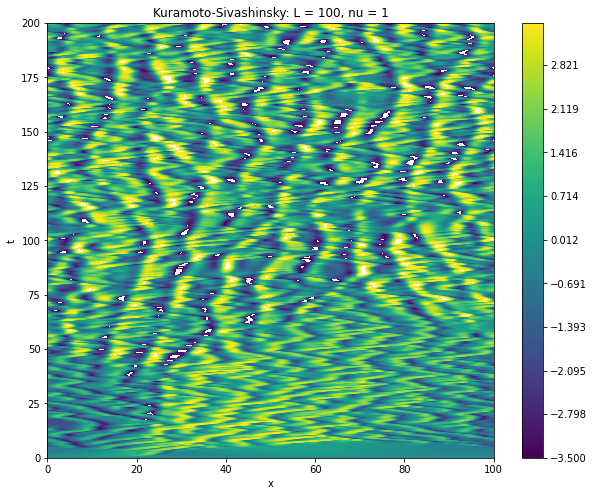

In [ ]:
plot_KS(u_np - jnp.real(u[0]))

Note that the majority of the runtime 

In [ ]:
u = jnp.empty((3, nt, nx), dtype=jnp.complex128)

# set initial condition in real and Fourier space
u = u.at[0,0].set( jnp.cos((2 * jnp.pi * x) / L) + 0.1 * jnp.cos((4 * jnp.pi * x) / L) )
u = u.at[1,0].set( (1 / nx) * fft(u[0,0])    )
u = u.at[2,0].set( (1 / nx) * fft(u[0,0]**2) )

# first timestep (no advanced restarting, just Euler)
u = u.at[1,1].set( CN2 * ( CN1 * u[1,0] + FN * u[2,0] * dt) )

# auxiliaries of first timestep
u = u.at[0,1].set( nx * jnp.real(ifft(u[1,1])) )
u = u.at[2,1].set( (1 / nx) * fft(u[0,1]**2)   )


# compute solution through time via finite difference method in Fourier space
u = jax.lax.fori_loop(1,nt-1,finite_step,u) 

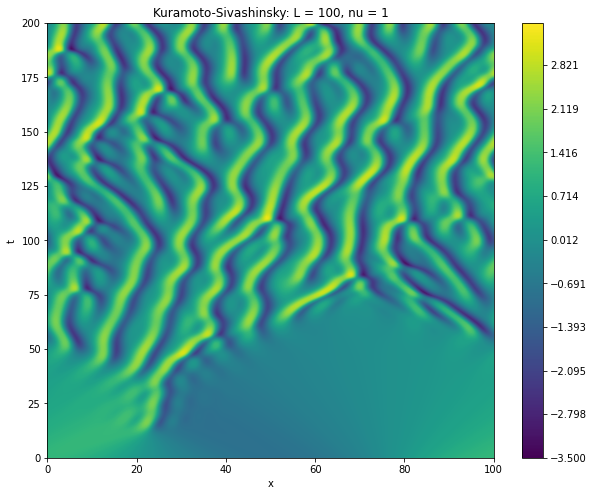

In [ ]:
# plot the result
plot_KS(np.real(u[0]))